In [1]:
import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 14})

# Setting up the system

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=2, F1=7 / 2, F=4
    )
]

polarizations = [[couplings.polarization_Z]]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.CoupledBasisState(
            J=2,
            F=3,
            F1=5 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=+1,
            electronic_state=states.ElectronicState.X,
        )
    ],
    excited_mains=[
        1
        * states.CoupledBasisState(
            J=3,
            F=4,
            F1=7 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        )
    ],
)

In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="phase_modulation(t, β, ωphase)*rabi_from_intensity(gaussian_2d_rotated(vz*t, y0+vy*t, peak_intensity, laser_center, 0.0, σz, σy, θ), main_coupling)",
    peak_intensity=1000.0,
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
    y0=0.0,
    vy=0.0,
    σz=1.04e-3,
    σy=4.53e-4,
    laser_center=5e-3,
    θ=4.19,
    main_coupling=0.5,
)

In [5]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans, transition_selectors, verbose=True, qn_compact=True, decay_channels=None
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


ValueError: j values must be integer or half integer and fulfill the triangle relation

In [6]:
[QN.largest for QN in obe_system_original.QN]

NameError: name 'obe_system_original' is not defined

In [ ]:
obe_system_original.H_symbolic

Matrix([
[-251619072761.694,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                0,                 0,                 0,                 0,                 0,                          0,                         0,           0,                          0,                         0,                         0,                         0,               0,             0,                        0,                        0,          0,                        0,                       0,                        0,                        0,               0],
[                0, -251619072761.595,                 0,                 0,                 0,                 0,                 0,                 0,                0,                 0,                 0,                 0,                 0,                          0,                         0,           0,                          0,        

In [ ]:
from copy import deepcopy

obe_system_python = deepcopy(obe_system_original)


In [ ]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_python, transition_selectors, odepars
)

In [ ]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 3, F₁ = 7/2, F = 4>"
states,
"|X, J = 2>",0.530151
"|X, J = 4>",0.469849


# Single trajectory run

In [ ]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=2, F=3, electronic=states.ElectronicState.X), obe_system.QN
)


In [ ]:
power = 25e-3

odepars.σz = 1.04e-3
odepars.σy = 4.53e-4

peak_intensity = power / (2 * np.pi * odepars.σz * odepars.σy)


In [ ]:
odepars.β = 0
odepars.main_coupling = obe_system.couplings[0].main_coupling.real
odepars.laser_center = 5 * odepars.σz


problem = lindblad_julia.OBEProblem(
    odepars, ρ, tspan=(0, (2 * odepars.laser_center) / odepars.vz)
)
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)


In [ ]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [ ]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


2.13 photons


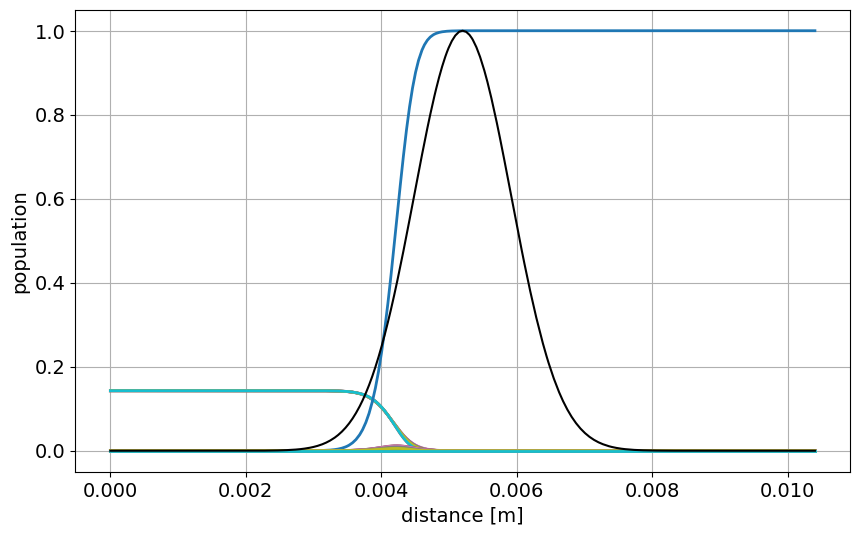

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results.t * odepars.vz, results.y.T, lw=2)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
# ax.legend(fontsize = 14)

lc = odepars.get_parameter_evolution(results.t, "Ω0")
ax.plot(results.t * odepars.vz, lc / lc.max(), color="k")

ax.grid(True)

nphotons_prerc = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons_prerc:.2f} photons")

# Scan detuning and power

In [ ]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [ ]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [ ]:
vx = np.linspace(-8, 8, 151)
powers = np.linspace(0, 100e-3, 101)
peak_intensities = powers / (2 * np.pi * odepars.σz * odepars.σy)

## Run simulation

In [ ]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    abstol=1e-10,
    reltol=1e-7,
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))

scan_values = [vx, peak_intensities]
parameters = ["vx", "peak_intensity"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(ensemble_problem)


In [ ]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


CPU times: total: 609 ms
Wall time: 12min 32s


In [ ]:
results = lindblad_julia.get_results_parameter_scan(ensemble_problem)

## Results

INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral


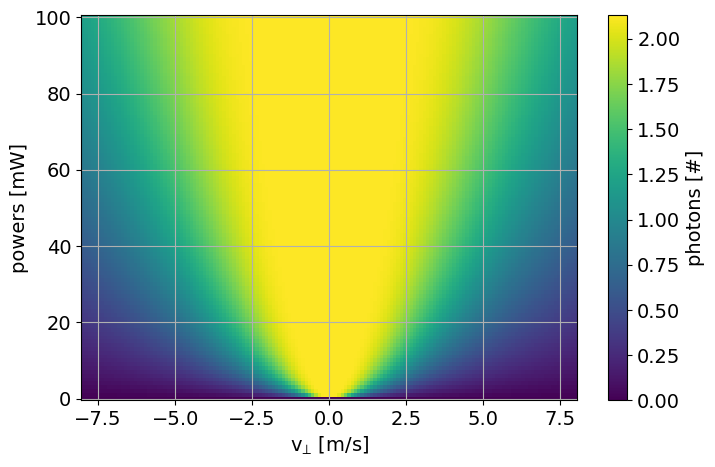

In [ ]:
(x, y), z = results.scan_values, results.results

fig, ax = plt.subplots(figsize=(8, 5))

c = ax.pcolormesh(x, y * (2 * np.pi * odepars.σz * odepars.σy) * 1e3, z)
cbar = fig.colorbar(c)

ax.set_xlabel("v$_⟂$ [m/s]")
ax.set_ylabel("powers [mW]")
cbar.ax.set_ylabel("photons [#]")
ax.grid(True)


INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral


INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral


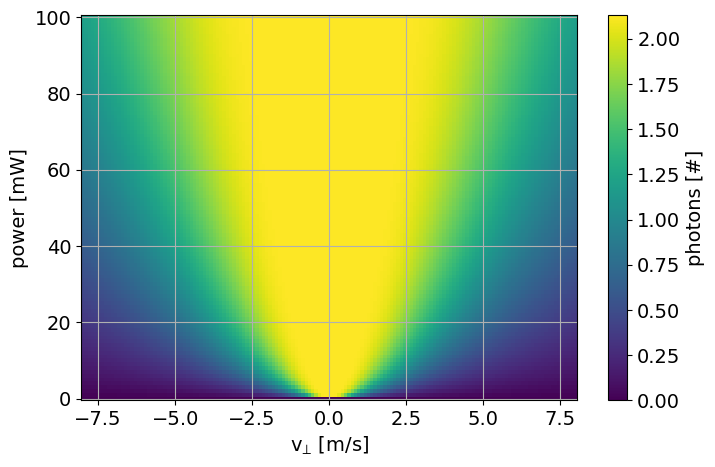

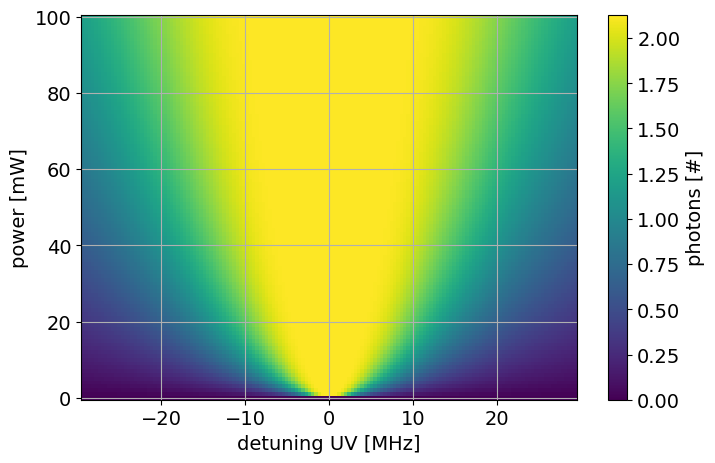

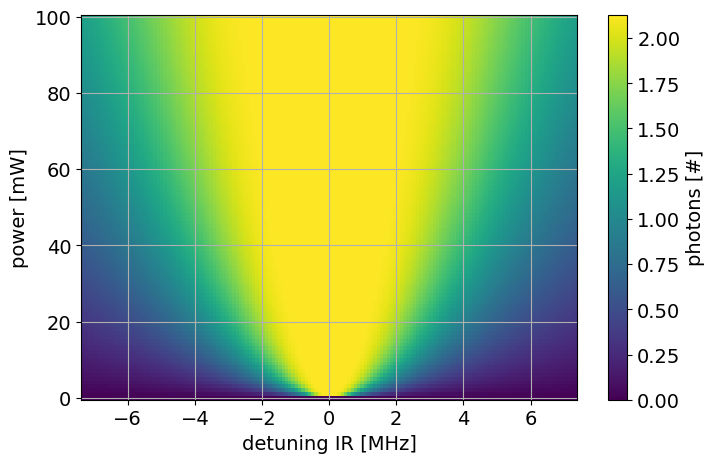

In [ ]:
z = results.results
x, y = np.meshgrid(*[vx, powers], indexing="ij")

fig, ax = plt.subplots(figsize=(8, 5))

c = ax.pcolormesh(x, y * 1e3, z)
cbar = fig.colorbar(c)

ax.set_xlabel("v$_⟂$ [m/s]")
ax.set_ylabel("power [mW]")
cbar.ax.set_ylabel("photons [#]")
ax.grid(True)

z = results.results
x, y = np.meshgrid(*[vx, powers], indexing="ij")

x = utils.detuning.velocity_to_detuning(x) / (2 * np.pi * 1e6)

fig, ax = plt.subplots(figsize=(8, 5))

c = ax.pcolormesh(x, y * 1e3, z)
cbar = fig.colorbar(c)

ax.set_xlabel("detuning UV [MHz]")
ax.set_ylabel("power [mW]")
cbar.ax.set_ylabel("photons [#]")
ax.grid(True)

fig, ax = plt.subplots(figsize=(8, 5))

c = ax.pcolormesh(x / 4, y * 1e3, z)
cbar = fig.colorbar(c)

ax.set_xlabel("detuning IR [MHz]")
ax.set_ylabel("power [mW]")
cbar.ax.set_ylabel("photons [#]")
ax.grid(True)


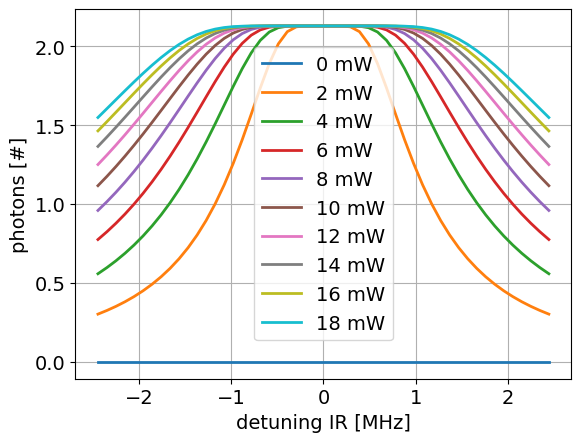

In [ ]:
z = results.results
x, y = np.meshgrid(*[vx, powers], indexing="ij")

xi = utils.detuning.velocity_to_detuning(x[:, 0]) / (2 * np.pi * 1e6 * 4)

r = 2.5
mask = (xi >= -r) & (xi <= r)

fig, ax = plt.subplots()
for p in powers[:20:2]:
    idy = np.argmin(np.abs(powers - p))
    ax.plot(xi[mask], z[mask, idy], lw=2, label=f"{p*1e3:.0f} mW")

ax.set_xlabel("detuning IR [MHz]")
ax.set_ylabel("photons [#]")
ax.legend()
ax.grid()


In [ ]:
from scipy.optimize import curve_fit


def lorentzian(x: float, amplitude: float, center: float, gamma: float) -> float:
    return amplitude / np.pi * gamma**2 / ((x - center) ** 2 + gamma**2)


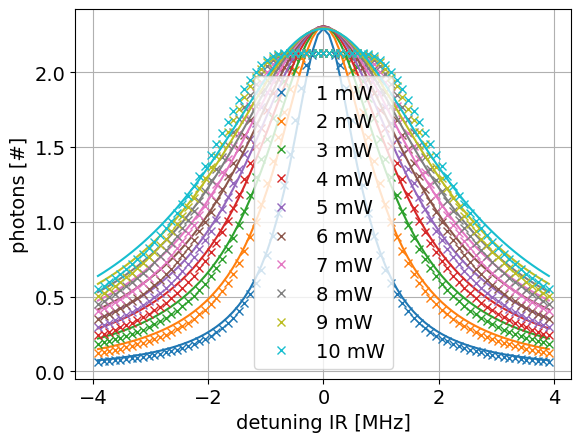

In [ ]:
z = results.results
x, y = np.meshgrid(*[vx, powers], indexing="ij")

xi = utils.detuning.velocity_to_detuning(x[:, 0]) / (2 * np.pi * 1e6 * 4)

r = 4
mask = (xi >= -r) & (xi <= r)

fits = []
fig, ax = plt.subplots()
for p in powers:
    if p == 0:
        continue
    idy = np.argmin(np.abs(powers - p))
    popt, pcov = curve_fit(
        lorentzian, xi[mask], z[mask, idy], p0=[2.0, 0, 1], bounds=[0, (100, 100, 100)]
    )
    fits.append((popt, pcov))
    if idy <= 10 and idy > 0:
        line = ax.plot(xi[mask], z[mask, idy], "x", lw=2, label=f"{p*1e3:.0f} mW")
        ax.plot(xi[mask], lorentzian(xi[mask], *popt), color=line[0].get_color())


ax.set_xlabel("detuning IR [MHz]")
ax.set_ylabel("photons [#]")
ax.legend()
ax.grid()


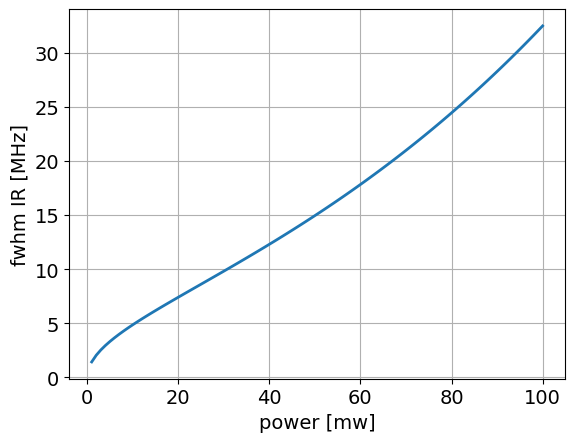

In [ ]:
fwhm = [p[2] * 2 for p, _ in fits]
fig, ax = plt.subplots()

ax.plot(powers[1:] * 1e3, fwhm, lw=2)
ax.set_xlabel("power [mw]")
ax.set_ylabel("fwhm IR [MHz]")
ax.grid()


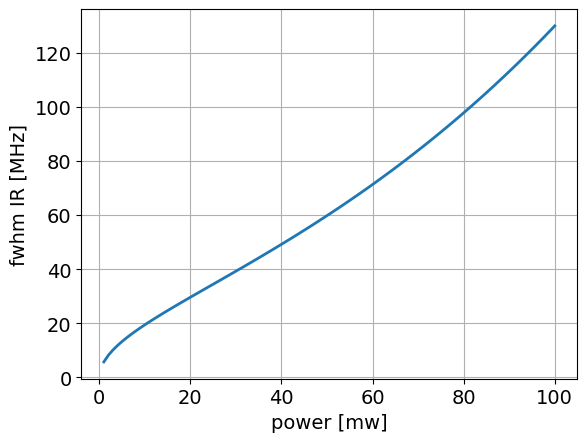

In [ ]:
fwhm = np.array([p[2] * 2 for p, _ in fits])
fig, ax = plt.subplots()

ax.plot(powers[1:] * 1e3, fwhm * 4, lw=2)
ax.set_xlabel("power [mw]")
ax.set_ylabel("fwhm IR [MHz]")
ax.grid()


In [ ]:
from scipy import stats

signal = np.empty(results.results.shape)

for idx, p in enumerate(powers):
    for idy, loc in enumerate(vx):
        dist = stats.norm(loc=loc, scale=0.349189)
        velocity_convolve = dist.pdf(vx)
        velocity_convolve /= velocity_convolve.sum()
        signal[idy, idx] = results.results[:, idx] @ velocity_convolve


In [ ]:
fwhms = np.zeros(results.results.shape[-1])
fwhms[0] = np.nan

fits = []

x = utils.detuning.velocity_to_detuning(vx) / (2 * np.pi * 1e6 * 4)
for idx in range(1, results.results.shape[-1]):
    popt, pcov = curve_fit(lorentzian, x, signal[:, idx], p0=[1, 0, 5])
    fits.append((np.abs(popt), pcov))
    fwhms[idx] = np.abs(popt[2] * 2 * np.sqrt(2 * np.log(2)))


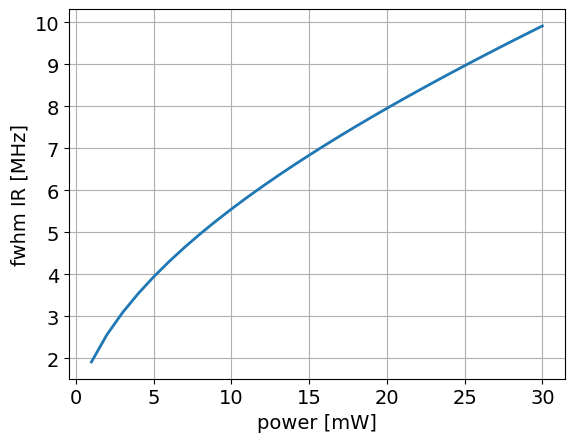

In [ ]:
mask = powers < 31e-3

fig, ax = plt.subplots()
ax.plot(powers[mask] * 1e3, fwhms[mask], lw=2)
ax.set_xlabel("power [mW]")
ax.set_ylabel("fwhm IR [MHz]")
ax.grid()


σ = -8.96 MHz
fwhm = -21.10 MHz


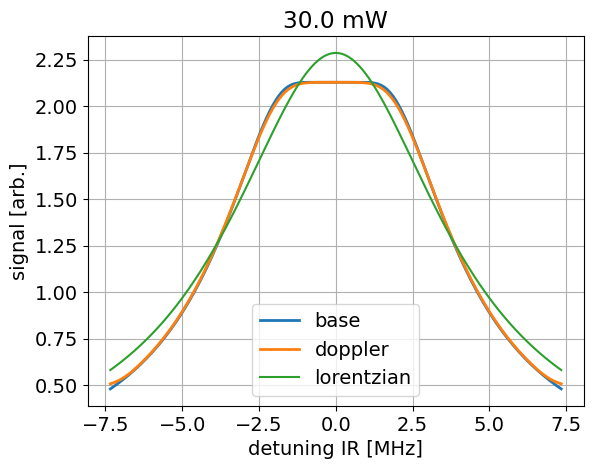

In [ ]:
idx = 30

fig, ax = plt.subplots()

ax.plot(x, results.results[:, idx], lw=2, label="base")
ax.plot(x, signal[:, idx], lw=2, label="doppler")
ax.plot(x, lorentzian(x, *fits[idx][0]), label="lorentzian")

ax.set_xlabel("detuning IR [MHz]")
ax.set_ylabel("signal [arb.]")
ax.set_title(f"{powers[idx]*1e3:.1f} mW")
ax.legend()
ax.grid()

print(f"σ = {popt[2]:.2f} MHz")
print(f"fwhm = {popt[2]*2*np.sqrt(2*np.log(2)):.2f} MHz")


In [ ]:
from scipy import stats

signal = np.empty(results.results.shape)

for idx, p in enumerate(powers):
    for idy, loc in enumerate(vx):
        dist = stats.norm(loc=loc, scale=0.349189)
        velocity_convolve = dist.pdf(vx)
        velocity_convolve
        signal[idy, idx] = results.results[:, idx] @ velocity_convolve


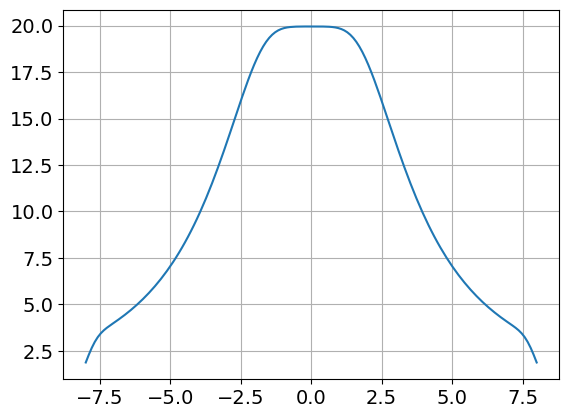

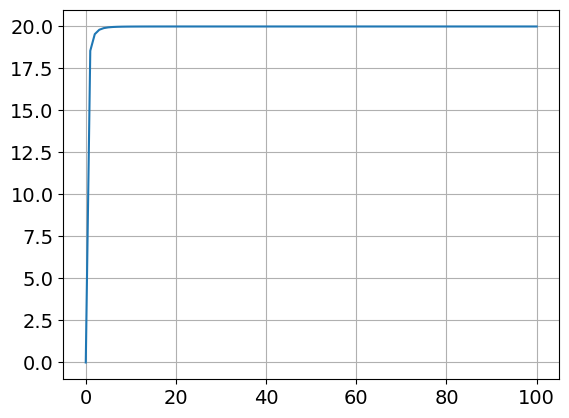

In [ ]:
fig, ax = plt.subplots()

ax.plot(vx, signal[:, 20])

ax.grid()


fig, ax = plt.subplots()

ax.plot(powers * 1e3, signal[151 // 2, :])

ax.grid()
